In [40]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn import model_selection, ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore the annoying warnings (from sklearn and seaborn)
color = sns.color_palette()
sns.set_style('darkgrid')

train = pd.read_csv('C:/Users/Luke/Downloads/titanic/train.csv')
test = pd.read_csv('C:/Users/Luke/Downloads/titanic/test.csv')

train['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([train, test])

all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

In [41]:
#Checking for null values:

print('Train columns with null values:\n', train_copy.isnull().sum())
print("---------------")

print('Test columns with null values:\n', test.isnull().sum())
print("---------------")

train.describe(include = "all")

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
---------------
Test columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
train_test       0
Survived       418
dtype: int64
---------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889,891.0
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3,NaN
top,NaN,NaN,NaN,"Emanuel, Miss. Virginia Ethel",male,NaN,NaN,NaN,1601,NaN,G6,S,NaN
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644,NaN
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN,1.0
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN,0.0
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN,1.0
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN,1.0
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,1.0
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN,1.0


In [42]:
#Separate numeric and categorical variables

df_num = train[['Age', 'SibSp', 'Parch', 'Fare']]
df_cat = train[['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']]

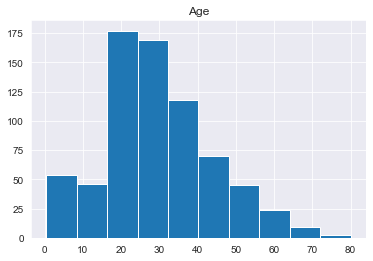

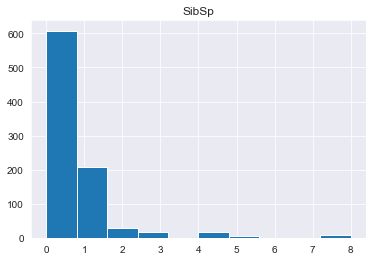

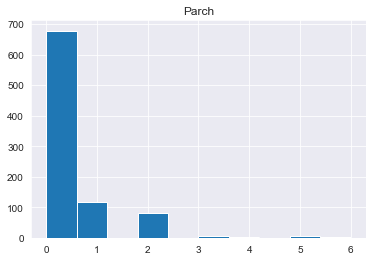

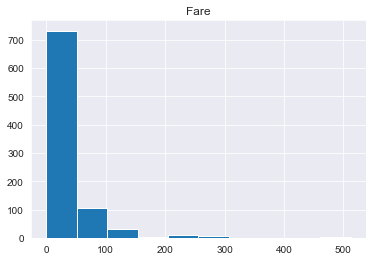

In [43]:
#distributions for numeric variables 
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

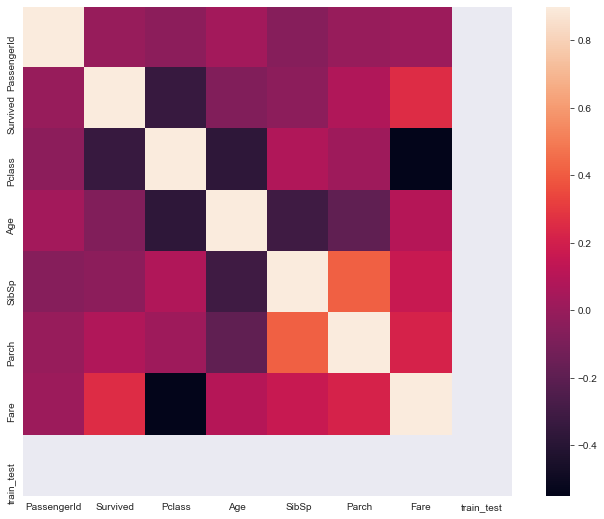

In [44]:
#Correlation map to see how features are correlated with Survived and with each other
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

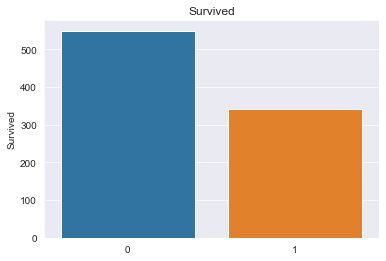

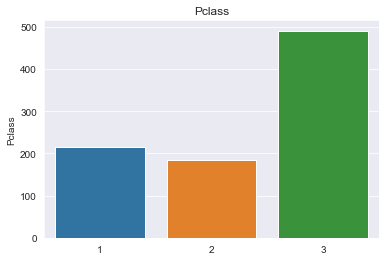

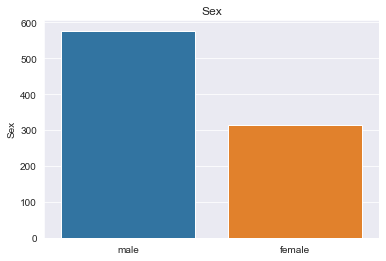

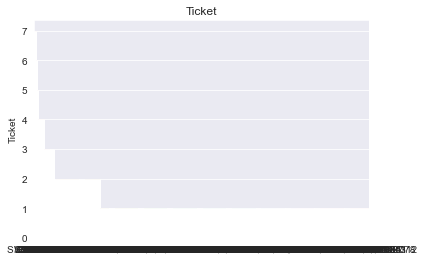

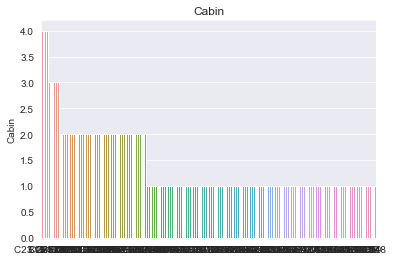

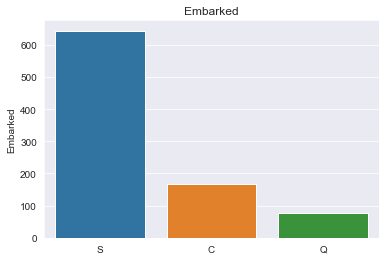

In [45]:
for i in df_cat.columns:
    sns.barplot(df_cat[i].value_counts().index,df_cat[i].value_counts()).set_title(i)
    plt.show()    

In [46]:
train['cabin_multiple'] = train.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))

train['cabin_multiple'].value_counts()

0    687
1    180
2     16
3      6
4      2
Name: cabin_multiple, dtype: int64

In [47]:
pd.pivot_table(train, index = 'Survived', columns = 'cabin_multiple', values = 'Ticket', aggfunc = 'count')

cabin_multiple,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


In [48]:
#So people who shared a cabin had a much higher chance of survival.

train['cabin_adv'] = train.Cabin.apply(lambda x: str(x)[0])
#n = null
print(train.cabin_adv.value_counts())
pd.pivot_table(train, index='Survived', columns='cabin_adv', values='Name', aggfunc='count')

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_adv, dtype: int64


cabin_adv,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


In [50]:
#Filling in or removing missing values in train and test datasets

#Age and Pclass are most related, so will group by Pclass and then get the median age
all_data.Age = all_data.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.mean()))
    
all_data.Embarked.fillna(all_data.Embarked.mode()[0], inplace = True)
    
#Fare and Pclass are most related, so once again groupby & get median
all_data.Fare = all_data.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))

#delete the useless columns
drop_column = ['PassengerId', 'Ticket']
train.drop(drop_column, axis=1, inplace = True)

print(all_data.isnull().sum())
print("--------------")
print(test.isnull().sum())

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
train_test        0
dtype: int64
--------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
train_test       0
Survived       418
dtype: int64


In [51]:
#Creating new features
#Getting FamilySize from Sibling and Parent counts
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1

all_data['IsAlone'] = 1 
all_data['IsAlone'].loc[all_data['FamilySize'] > 1] = 0

all_data['Title'] = all_data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

#Group rare title names into "Other"
stat_min = 10 
title_names = (all_data['Title'].value_counts() < stat_min) 

all_data['Title'] = all_data['Title'].apply(lambda x: 'Other' if title_names.loc[x] == True else x)
print(all_data['Title'].value_counts())

Mr        757
Miss      260
Mrs       197
Master     61
Other      34
Name: Title, dtype: int64


<AxesSubplot:xlabel='FamilySize', ylabel='Survived'>

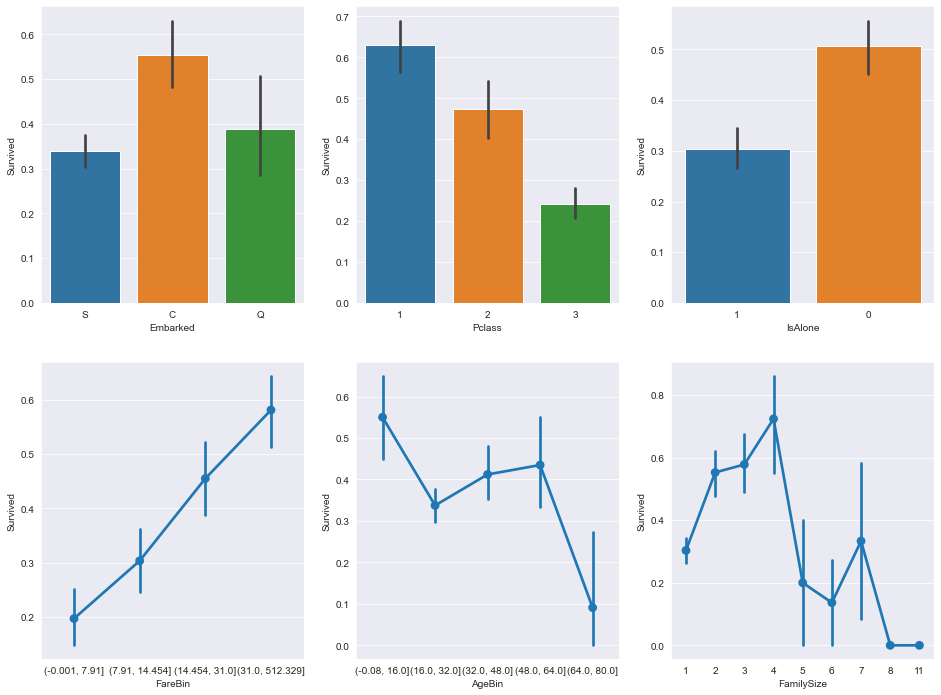

In [9]:
#graph individual features by survival
fig, saxis = plt.subplots(2, 3,figsize=(16,12))

sns.barplot(x = 'Embarked', y = 'Survived', data=train, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=train, ax = saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived', order=[1,0], data=train, ax = saxis[0,2])

In [ ]:
sns.catplot(x="Sex", y="Survived", kind="bar", data=train)
sns.catplot(x="FamilySize", y="Survived", kind="bar", data=train)

In [ ]:
sns.catplot(x="Survived", y="Age", hue="Sex", kind="swarm", data=train)

In [ ]:
#ALL THE DATA!
pp = sns.pairplot(train_copy, hue = 'Survived', palette = 'deep', size=1.2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10) )
pp.set(xticklabels=[])

In [ ]:
#correlation heatmap 
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Correlation Heatmap', y=1.05, size=15)

correlation_heatmap(train_copy)

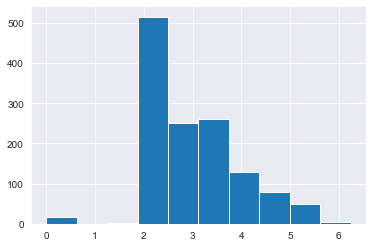

In [52]:
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])
       
# log transform of fare
all_data['norm_fare'] = np.log(all_data.Fare+1)
all_data['norm_fare'].hist()


all_data.Pclass = all_data.Pclass.astype(str)

all_dummies = pd.get_dummies(all_data[['Pclass','Sex','Age','FamilySize','IsAlone','SibSp','Parch','norm_fare','Embarked','cabin_adv','cabin_multiple','Title','train_test']])

In [53]:
#Splitting data to train test

X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis =1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis =1)


y_train = all_data[all_data.train_test==1].Survived
y_train.shape


(891,)

In [54]:
#Scaling data 
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age','SibSp','Parch','norm_fare', 'FamilySize', 'IsAlone']]= scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare','FamilySize', 'IsAlone']])
all_dummies_scaled

X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived

In [62]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [63]:
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.7150838  0.73595506 0.75280899 0.76404494 0.80898876]
0.7553763103383341


In [64]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.81564246 0.8258427  0.80898876 0.8258427  0.84831461]
0.8249262444291006


In [65]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.81564246 0.8258427  0.80898876 0.8258427  0.84831461]
0.8249262444291006


In [66]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.76536313 0.76404494 0.81460674 0.75842697 0.79775281]
0.7800389178331555


In [67]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.76536313 0.76404494 0.81460674 0.75842697 0.80337079]
0.7811625133387735


In [68]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.77094972 0.7752809  0.79775281 0.81460674 0.8258427 ]
0.7968865733475614


In [69]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.79329609 0.78651685 0.81460674 0.80898876 0.85955056]
0.8125918021467579


In [70]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.82122905 0.79775281 0.83146067 0.74719101 0.8258427 ]
0.8046952482581131


In [71]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.82122905 0.79775281 0.83707865 0.74719101 0.8258427 ]
0.805818843763731


In [72]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.84357542 0.8258427  0.82022472 0.80337079 0.86516854]
0.8316364321134895


In [73]:
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.79888268 0.80898876 0.85393258 0.78089888 0.84269663]
0.817079907099366


In [74]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)], voting = 'soft') 

In [75]:
cv = cross_val_score(voting_clf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.82681564 0.81460674 0.8258427  0.80337079 0.87078652]
0.8282844768062269


In [76]:
voting_clf.fit(X_train_scaled,y_train)
y_base_predict = voting_clf.predict(X_test_scaled).astype(int)
basic_submission = {'PassengerId': test.PassengerId, 'Survived': y_base_predict}
base_submission = pd.DataFrame(data=basic_submission)
base_submission.to_csv('base_submission.csv', index=False)

In [78]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [79]:
#Performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [80]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train_scaled,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.0s


Logistic Regression
Best Score: 0.8260498399347185
Best Parameters: {'C': 1.623776739188721, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.0s finished


In [81]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:    1.1s


KNN
Best Score: 0.8227167158370472
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.3s finished


In [82]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:  1.9min


SVC
Best Score: 0.8316364321134895
Best Parameters: {'C': 1, 'degree': 2, 'kernel': 'poly'}


[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:  3.0min finished


In [83]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [100,500,1000], 
                                  'bootstrap': [True,False],
                                  'max_depth': [3,5,10,20,50,75,100,None],
                                  'max_features': ['auto','sqrt'],
                                  'min_samples_leaf': [1,2,4,10],
                                  'min_samples_split': [2,5,10]}
                                  
clf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf_rnd = clf_rf_rnd.fit(X_train_scaled,y_train)
clf_performance(best_clf_rf_rnd,'Random Forest')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min


Random Forest
Best Score: 0.8338836231247255
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 75, 'bootstrap': False}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.3min finished


In [85]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [50,100,150,200,250],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [70, 75, 80, 90],
                                  'max_features': ['auto','sqrt', 10],
                                  'min_samples_leaf': [2, 3],
                                  'min_samples_split': [8, 9, 10, 11]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train_scaled,y_train)
clf_performance(best_clf_rf,'Random Forest')

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  8.9min finished


Random Forest
Best Score: 0.8406189190885694
Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 70, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 100}


In [87]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [20, 50, 100, 250, 500,1000],
    'colsample_bytree': [0.2, 0.5, 0.7, 0.8, 1],
    'max_depth': [2, 5, 10, 15, 20, 25, None],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2],
    'subsample': [0.5,0.6,0.7, 0.8, 0.9],
    'learning_rate':[.01,0.1,0.2,0.3,0.5, 0.7, 0.9],
    'gamma':[0,.01,.1,1,10,100],
    'min_child_weight':[0,.01,0.1,1,10,100],
    'sampling_method': ['uniform', 'gradient_based']
}

clf_xgb_rnd = RandomizedSearchCV(xgb, param_distributions = param_grid, n_iter = 1000, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb_rnd = clf_xgb_rnd.fit(X_train_scaled,y_train)
clf_performance(best_clf_xgb_rnd,'XGB')

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 642 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 1992 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3010 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4142 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  5.0min finished


XGB
Best Score: 0.8518485970748854
Best Parameters: {'subsample': 0.9, 'sampling_method': 'uniform', 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 0, 'max_depth': 5, 'learning_rate': 0.5, 'gamma': 1, 'colsample_bytree': 1}


In [89]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [450,500,550],
    'colsample_bytree': [0.85, 0.9, 0.95],
    'max_depth': [4, 5, 6, 7, 8],
    'reg_alpha': [0.5],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.85, 0.9, .95],
    'learning_rate':[0.5],
    'gamma':[0.5,1,2],
    'min_child_weight':[0],
    'sampling_method': ['uniform']
}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train_scaled,y_train)
clf_performance(best_clf_xgb,'XGB')

Fitting 5 folds for each of 1215 candidates, totalling 6075 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 33.7min
[Parallel(n_jobs=-1)]: Done 6075 out of 6075 | elapsed: 34.0min finished


XGB
Best Score: 0.8563429790973573
Best Parameters: {'colsample_bytree': 0.85, 'gamma': 1, 'learning_rate': 0.5, 'max_depth': 5, 'min_child_weight': 0, 'n_estimators': 550, 'reg_alpha': 0.5, 'reg_lambda': 5, 'sampling_method': 'uniform', 'subsample': 0.9}


In [90]:
y_hat_xgb = best_clf_xgb.best_estimator_.predict(X_test_scaled).astype(int)
xgb_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_xgb}
submission_xgb = pd.DataFrame(data=xgb_submission)
submission_xgb.to_csv('xgb_submission3.csv', index=False)

In [98]:
best_lr = best_clf_lr.best_estimator_
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
best_rf = best_clf_rf.best_estimator_
best_xgb = best_clf_xgb.best_estimator_

voting_clf_hard = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'hard') 
voting_clf_soft = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'soft')
voting_clf_all = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('lr', best_lr)], voting = 'soft') 
voting_clf_xgb = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('xgb', best_xgb),('lr', best_lr)], voting = 'soft')

print('voting_clf_hard :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5))
print('voting_clf_hard mean :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5).mean())

print('voting_clf_soft :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5))
print('voting_clf_soft mean :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5).mean())

print('voting_clf_all :',cross_val_score(voting_clf_all,X_train,y_train,cv=5))
print('voting_clf_all mean :',cross_val_score(voting_clf_all,X_train,y_train,cv=5).mean())

print('voting_clf_xgb :',cross_val_score(voting_clf_xgb,X_train,y_train,cv=5))
print('voting_clf_xgb mean :',cross_val_score(voting_clf_xgb,X_train,y_train,cv=5).mean())

voting_clf_hard : [0.82122905 0.80898876 0.83146067 0.79213483 0.85955056]
voting_clf_hard mean : 0.8226727763480008
voting_clf_soft : [0.81005587 0.80898876 0.8258427  0.82022472 0.85393258]
voting_clf_soft mean : 0.8238089259933463
voting_clf_all : [0.83240223 0.80898876 0.80898876 0.8258427  0.87078652]
voting_clf_all mean : 0.8294017952419811
voting_clf_xgb : [0.83798883 0.83146067 0.84831461 0.8258427  0.86516854]
voting_clf_xgb mean : 0.840631473228297


In [99]:
params = {'weights' : [[1,1,1],[1,2,1],[1,1,2],[2,1,1],[2,2,1],[1,2,2],[2,1,2]]}

vote_weight = GridSearchCV(voting_clf_soft, param_grid = params, cv = 5, verbose = True, n_jobs = -1)
best_clf_weight = vote_weight.fit(X_train_scaled,y_train)
clf_performance(best_clf_weight,'VC Weights')
voting_clf_sub = best_clf_weight.best_estimator_.predict(X_test_scaled)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.9s finished


VC Weights
Best Score: 0.8327600276191074
Best Parameters: {'weights': [1, 1, 1]}


In [100]:
#Make Predictions 
voting_clf_hard.fit(X_train_scaled, y_train)
voting_clf_soft.fit(X_train_scaled, y_train)
voting_clf_all.fit(X_train_scaled, y_train)
voting_clf_xgb.fit(X_train_scaled, y_train)

best_rf.fit(X_train_scaled, y_train)
y_hat_vc_hard = voting_clf_hard.predict(X_test_scaled).astype(int)
y_hat_rf = best_rf.predict(X_test_scaled).astype(int)
y_hat_vc_soft =  voting_clf_soft.predict(X_test_scaled).astype(int)
y_hat_vc_all = voting_clf_all.predict(X_test_scaled).astype(int)
y_hat_vc_xgb = voting_clf_xgb.predict(X_test_scaled).astype(int)

In [101]:
#convert output to dataframe 
final_data = {'PassengerId': test.PassengerId, 'Survived': y_hat_rf}
submission = pd.DataFrame(data=final_data)

final_data_2 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_hard}
submission_2 = pd.DataFrame(data=final_data_2)

final_data_3 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_soft}
submission_3 = pd.DataFrame(data=final_data_3)

final_data_4 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_all}
submission_4 = pd.DataFrame(data=final_data_4)

final_data_5 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_xgb}
submission_5 = pd.DataFrame(data=final_data_5)

final_data_comp = {'PassengerId': test.PassengerId, 'Survived_vc_hard': y_hat_vc_hard, 'Survived_rf': y_hat_rf, 'Survived_vc_soft' : y_hat_vc_soft, 'Survived_vc_all' : y_hat_vc_all,  'Survived_vc_xgb' : y_hat_vc_xgb}
comparison = pd.DataFrame(data=final_data_comp)

In [103]:
#prepare submission files 
submission.to_csv('C:/Users/Luke/Downloads/titanic/submission_rf.csv', index =False)
submission_2.to_csv('C:/Users/Luke/Downloads/titanic/submission_vc_hard.csv',index=False)
submission_3.to_csv('C:/Users/Luke/Downloads/titanic/submission_vc_soft.csv', index=False)
submission_4.to_csv('C:/Users/Luke/Downloads/titanic/submission_vc_all.csv', index=False)
submission_5.to_csv('C:/Users/Luke/Downloads/titanic/submission_vc_xgb2.csv', index=False)